In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import scipy.stats as stats
from scipy.stats import linregress


In [2]:
# Reading CSV files into dataframes
daily_activity_df = pd.read_csv("dailyActivity_merged (1).csv")
fitbit_df = pd.read_csv("FitBit data.csv")

#check DataFrames 
daily_activity_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [3]:
fitbit_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,3/25/2016,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819
1,1503960366,3/26/2016,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154
2,1503960366,3/27/2016,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944
3,1503960366,3/28/2016,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932
4,1503960366,3/29/2016,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886


In [4]:
#merging the DataFrames
merged_df = pd.concat([daily_activity_df, fitbit_df], ignore_index=True)
merged_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [5]:
# Print the number of rows in the merged dataset
print("merged_df:", len(merged_df))

merged_df: 1397


In [6]:
# find the duplicate rows by  ID, activity date and total distance
duplicate_df = merged_df[merged_df.duplicated(subset=["Id", "ActivityDate", "TotalSteps"])]

# Remove duplicates from the original data based on specific columns
cleaned_data = merged_df.drop_duplicates(subset=['Id', 'ActivityDate', 'TotalSteps'])

# Calculate all active minutes and all active distance and add to df
cleaned_data['AllActiveMinutes'] = cleaned_data['LightlyActiveMinutes'] + cleaned_data['FairlyActiveMinutes'] + cleaned_data['VeryActiveMinutes']
cleaned_data['AllActiveDistance'] = cleaned_data['LightActiveDistance'] + cleaned_data['ModeratelyActiveDistance'] + cleaned_data['VeryActiveDistance']

#duplicate_df.to_csv("duplicates.csv", index=False)
#cleaned_data.to_csv("cleaned_data.csv", index=False)

In [7]:
# Ensure the activity_date column is in datetime format
cleaned_data["ActivityDate"] = pd.to_datetime(cleaned_data["ActivityDate"])

# Calculate the total number of activity dates for each ID
activity_counts = cleaned_data.groupby("Id")["ActivityDate"].nunique().reset_index()
activity_counts.columns = ["Id", "TotalActivityDates"]

# Calculate the total of all other columns for each ID
# Exclude the 'activity_date' column for the sum operation
columns_to_sum = cleaned_data.columns.difference(["ActivityDate"])

column_sums = cleaned_data[columns_to_sum].groupby("Id").sum().reset_index()

# Merge the two results
result = pd.merge(activity_counts, column_sums, on="Id")

# Rename columns to include the word 'Total' in each column header
result.columns = ['Sum' + col if col != 'Id' else col for col in result.columns]

# Display the final result
print(result)

            Id  SumTotalActivityDates  SumAllActiveDistance  \
0   1503960366                     49            386.320001   
1   1624580081                     49            173.139999   
2   1644430081                     40            226.140001   
3   1844505072                     42             81.719999   
4   1927972279                     42             37.790000   
5   2022484408                     42            355.919999   
6   2026352035                     42            132.300000   
7   2320127002                     42            124.199999   
8   2347167796                     32            212.050000   
9   2873212765                     42            211.580001   
10  2891001357                      8              4.830000   
11  3372868164                     30            135.889999   
12  3977333714                     41            294.529999   
13  4020332650                     62            132.290000   
14  4057192912                     35             55.37

In [8]:
# Add new column for total active minutes
result["TotalActiveMinutes"] = result["SumFairlyActiveMinutes"] + result["SumLightlyActiveMinutes"] + result["SumVeryActiveMinutes"]

# Add new column for total active distance
result["TotalActiveDistance"] = result["SumLightActiveDistance"] + result["SumModeratelyActiveDistance"] + result["SumVeryActiveDistance"]

# Display the final result with new columns
print(result)


            Id  SumTotalActivityDates  SumAllActiveDistance  \
0   1503960366                     49            386.320001   
1   1624580081                     49            173.139999   
2   1644430081                     40            226.140001   
3   1844505072                     42             81.719999   
4   1927972279                     42             37.790000   
5   2022484408                     42            355.919999   
6   2026352035                     42            132.300000   
7   2320127002                     42            124.199999   
8   2347167796                     32            212.050000   
9   2873212765                     42            211.580001   
10  2891001357                      8              4.830000   
11  3372868164                     30            135.889999   
12  3977333714                     41            294.529999   
13  4020332650                     62            132.290000   
14  4057192912                     35             55.37

In [9]:
# Calculate the average of each column
averages = result.mean()
# Exclude the Id column
averages_excluding_id = averages.drop("Id")
# Format the values to 4 decimal places
averages_formatted = averages_excluding_id.round(4)
print(averages_formatted)

SumTotalActivityDates              39.2286
SumAllActiveDistance              204.7317
SumAllActiveMinutes              8719.4857
SumCalories                     90456.3714
SumFairlyActiveMinutes            534.9714
SumLightActiveDistance            127.4626
SumLightlyActiveMinutes          7399.0286
SumLoggedActivitiesDistance         5.2480
SumModeratelyActiveDistance        21.4923
SumSedentaryActiveDistance          0.0680
SumSedentaryMinutes             39616.6286
SumTotalDistance                  208.3300
SumTotalSteps                  290611.8571
SumTrackerDistance                207.2437
SumVeryActiveDistance              55.7769
SumVeryActiveMinutes              785.4857
TotalActiveMinutes               8719.4857
TotalActiveDistance               204.7317
dtype: float64


In [10]:
# Define recommended guidelines
# rec dail activity in mins
rec_mins_pw = 90

# Rec daily steps
rec_daily_steps = 10000

In [11]:
# Calculate average daily active minutes and daily steps
result['AverageDailyActiveMinutes'] = result['TotalActiveMinutes'] / result['SumTotalActivityDates']
result['AverageDailySteps'] = result['SumTotalSteps'] / result['SumTotalActivityDates']

# Determine if they met the recommended daily active minutes and step count
result['Met daily rec activity mins'] = result['AverageDailyActiveMinutes'] >= rec_mins_pw
result['Met daily rec step count'] = result['AverageDailySteps'] >= rec_daily_steps

# Convert boolean values to 'TRUE'/'FALSE'
result['Met daily rec activity mins'] = result['Met daily rec activity mins'].apply(lambda x: 'TRUE' if x else 'FALSE')
result['Met daily rec step count'] = result['Met daily rec step count'].apply(lambda x: 'TRUE' if x else 'FALSE')

# Count the number of 'TRUE' values in the specified columns
true_activity_mins_count = result['Met daily rec activity mins'].value_counts().get('TRUE', 0)
true_step_count = result['Met daily rec step count'].value_counts().get('TRUE', 0)

# Print the counts
print(f"Number of ID's meeting recommended daily active minutes: {true_activity_mins_count}")
print(f"Number of ID's meeting recommended daily step count: {true_step_count}")

# Display the final result
print(result)

# convert to csv
#result.to_csv("result.csv", index=False)

Number of ID's meeting recommended daily active minutes: 32
Number of ID's meeting recommended daily step count: 7
            Id  SumTotalActivityDates  SumAllActiveDistance  \
0   1503960366                     49            386.320001   
1   1624580081                     49            173.139999   
2   1644430081                     40            226.140001   
3   1844505072                     42             81.719999   
4   1927972279                     42             37.790000   
5   2022484408                     42            355.919999   
6   2026352035                     42            132.300000   
7   2320127002                     42            124.199999   
8   2347167796                     32            212.050000   
9   2873212765                     42            211.580001   
10  2891001357                      8              4.830000   
11  3372868164                     30            135.889999   
12  3977333714                     41            294.529999   
13 

# Correlation between
- LightlyActiveMinutes vs. LightActiveDistance
- FairlyActiveMinutes vs. ModeratelyActiveDistance
- VeryActiveMinutes vs. VeryActiveDistance
- AllActiveMinutes vs. AllActiveDistance

Correlations between activity minutes and distances:
LightlyActiveMinutes vs. LightActiveDistance: 0.8762935452942788
FairlyActiveMinutes vs. ModeratelyActiveDistance: 0.6979928705143341
VeryActiveMinutes vs. VeryActiveDistance: 0.8348675153819457
AllActiveMinutes vs. AllActiveDistance: 0.7539476699627684
R-squared - LightlyActiveMinutes vs. LightActiveDistance: 0.7678903775244159


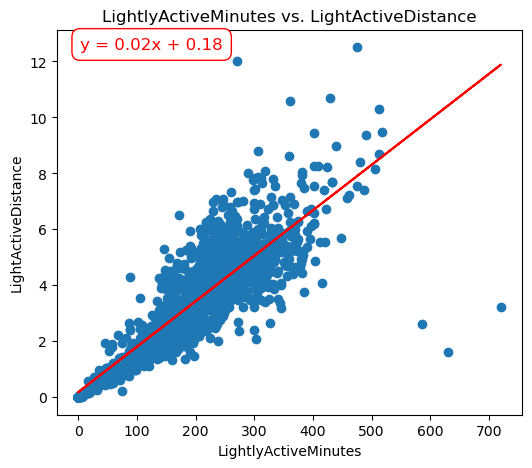

R-squared - FairlyActiveMinutes vs. ModeratelyActiveDistance: 0.487194047288842


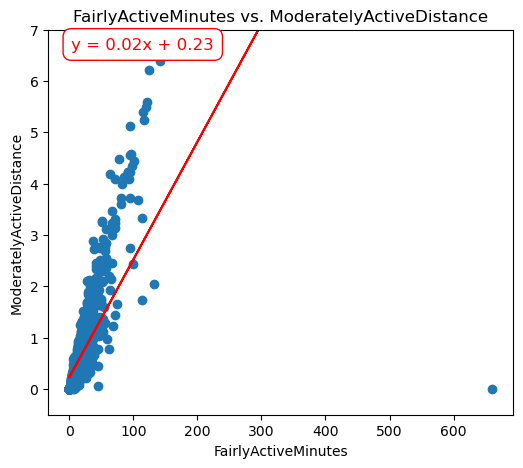

R-squared - VeryActiveMinutes vs. VeryActiveDistance: 0.6970037682400282


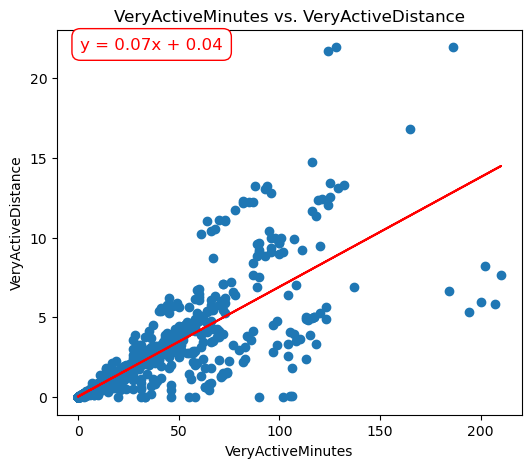

R-squared - AllActiveMinutes vs. AllActiveDistance: 0.5684370890422877


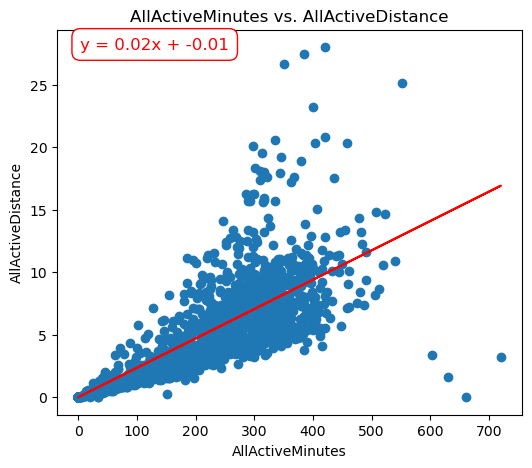

In [12]:
# Calculate the correlations between ActiviteMinutes vs ActiviteDistance
correlations = {
    'LightlyActiveMinutes vs. LightActiveDistance': cleaned_data[['LightlyActiveMinutes', 'LightActiveDistance']].corr().iloc[0, 1],
    'FairlyActiveMinutes vs. ModeratelyActiveDistance': cleaned_data[['FairlyActiveMinutes', 'ModeratelyActiveDistance']].corr().iloc[0, 1],
    'VeryActiveMinutes vs. VeryActiveDistance': cleaned_data[['VeryActiveMinutes', 'VeryActiveDistance']].corr().iloc[0, 1],
    'AllActiveMinutes vs. AllActiveDistance': cleaned_data[['AllActiveMinutes', 'AllActiveDistance']].corr().iloc[0, 1]
}

print("Correlations between activity minutes and distances:")
for key, value in correlations.items():
    print(f"{key}: {value}")

# LightlyActiveMinutes vs. LightActiveDistance
plt.figure(figsize=(6, 5))
plt.scatter(cleaned_data['LightlyActiveMinutes'], cleaned_data['LightActiveDistance'])
plt.xlabel('LightlyActiveMinutes')
plt.ylabel('LightActiveDistance')
plt.title('LightlyActiveMinutes vs. LightActiveDistance')
slope, intercept, r_value, p_value, std_err = stats.linregress(cleaned_data['LightlyActiveMinutes'], cleaned_data['LightActiveDistance'])
print(f"R-squared - LightlyActiveMinutes vs. LightActiveDistance: {r_value**2}")
plt.plot(cleaned_data['LightlyActiveMinutes'], intercept + slope * cleaned_data['LightlyActiveMinutes'], color='red')
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
#plt.savefig('LightlyActiveMinutes_vs_LightActiveDistance.png')
plt.show()

# FairlyActiveMinutes vs. ModeratelyActiveDistance
plt.figure(figsize=(6, 5))
plt.scatter(cleaned_data['FairlyActiveMinutes'], cleaned_data['ModeratelyActiveDistance'])
plt.xlabel('FairlyActiveMinutes')
plt.ylabel('ModeratelyActiveDistance')
plt.title('FairlyActiveMinutes vs. ModeratelyActiveDistance')
slope, intercept, r_value, p_value, std_err = stats.linregress(cleaned_data['FairlyActiveMinutes'], cleaned_data['ModeratelyActiveDistance'])
print(f"R-squared - FairlyActiveMinutes vs. ModeratelyActiveDistance: {r_value**2}")
plt.plot(cleaned_data['FairlyActiveMinutes'], intercept + slope * cleaned_data['FairlyActiveMinutes'], color='red')
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
# Set y-axis limits to make it smaller
plt.ylim(-0.5, 7) 
#plt.savefig('FairlyActiveMinutes_vs_ModeratelyActiveDistance.png')
plt.show()

# VeryActiveMinutes vs. VeryActiveDistance
plt.figure(figsize=(6, 5))
plt.scatter(cleaned_data['VeryActiveMinutes'], cleaned_data['VeryActiveDistance'])
plt.xlabel('VeryActiveMinutes')
plt.ylabel('VeryActiveDistance')
plt.title('VeryActiveMinutes vs. VeryActiveDistance')
slope, intercept, r_value, p_value, std_err = stats.linregress(cleaned_data['VeryActiveMinutes'], cleaned_data['VeryActiveDistance'])
plt.plot(cleaned_data['VeryActiveMinutes'], intercept + slope * cleaned_data['VeryActiveMinutes'], color='red')
print(f"R-squared - VeryActiveMinutes vs. VeryActiveDistance: {r_value**2}")
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
#plt.savefig('VeryActiveMinutes_vs_VeryActiveDistance.png')
plt.show()

# AllActiveMinutes vs. AllActiveDistance
plt.figure(figsize=(6, 5))
plt.scatter(cleaned_data['AllActiveMinutes'], cleaned_data['AllActiveDistance'])
plt.xlabel('AllActiveMinutes')
plt.ylabel('AllActiveDistance')
plt.title('AllActiveMinutes vs. AllActiveDistance')
slope, intercept, r_value, p_value, std_err = stats.linregress(cleaned_data['AllActiveMinutes'], cleaned_data['AllActiveDistance'])
plt.plot(cleaned_data['AllActiveMinutes'], intercept + slope * cleaned_data['AllActiveMinutes'], color='red')
print(f"R-squared - AllActiveMinutes vs. AllActiveDistance: {r_value**2}")
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
#plt.savefig('AllActiveMinutes_vs_AllActiveDistance.png')
plt.show()

# Analysis

All the graphs show there is a atrong positive correaltion between active minutes and the corresponding distances for light and very active activities, and a moderate positive correlation for moderate activities. This indicates that there is a correlation between active distances and active minutes and that as users spend more time being active, they cover more distance, showing consistent tracking by Fitbit.

The data indicates that users are engaging in various levels of activity, and Fitbit is accurately capturing these activities, which can motivate users to continue meeting or exceeding their exercise goals if they know there steps are being tracked consistently.

Users who spend more time in lightly active minutes tend to cover more distance. This suggests that light activities, like walking, are consistently tracked and directly proportional to the duration spent. Users who engage in very active minutes typically cover significant distances. This strong correlation suggests that very active activities are consistently tracked and that the duration spent on these activities is a good indicator of the distance covered.

The strong correlations and consistent tracking suggest that having a Fitbit inspires users to be more active, as they can reliably track their activity minutes and distances. 
Overall, the analysis supports the idea that Fitbit is an effective tool for tracking and inspiring physical activity, helping users to meet their exercise goals by providing accurate and reliable data on their activity levels.

However, the spread of users who spend more total active minutes (sum of light, fairly, and very active minutes) indicates that the relationship is not perfectly linear, possibly due to differences in individual activity patterns and intensities.

# Distribution of TotalSteps against TotalActiveMinutes

Slope: 31.39884517130186
Intercept: 421.65542801127776
R-squared: 0.6010558569437321
P-value: 1.1915076931267748e-280
Standard Error: 0.6848969016344354


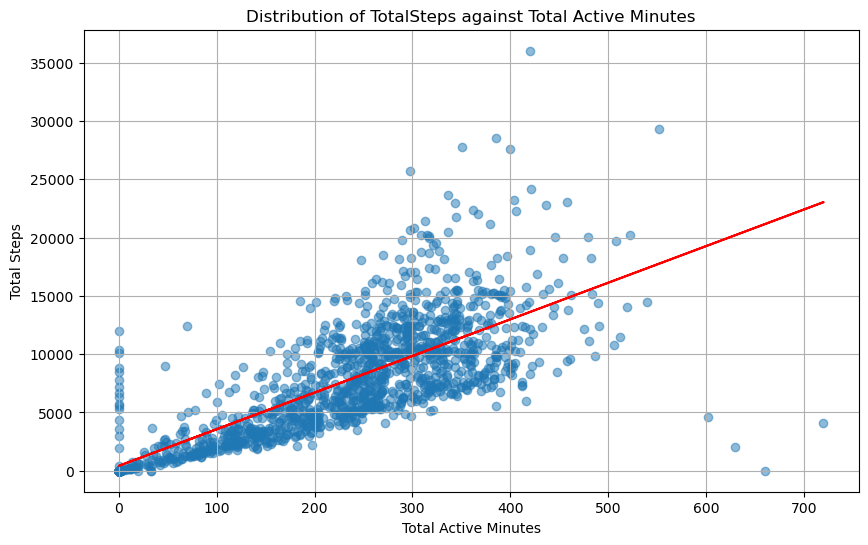

In [19]:
# Calculate total active minutes
cleaned_data['TotalActiveMinutes'] = cleaned_data['LightlyActiveMinutes'] + cleaned_data['FairlyActiveMinutes'] + cleaned_data['VeryActiveMinutes']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cleaned_data['TotalActiveMinutes'], cleaned_data['TotalSteps'])
# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

# Plot the distribution of TotalSteps against TotalActiveMinutes
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['TotalActiveMinutes'], cleaned_data['TotalSteps'], alpha=0.5)
plt.title('Distribution of TotalSteps against Total Active Minutes')
plt.xlabel('Total Active Minutes')
plt.ylabel('Total Steps')
plt.grid(True)

# Plot the linear regression line
plt.plot(cleaned_data['TotalActiveMinutes'], intercept + slope * cleaned_data['TotalActiveMinutes'], color='red', label=f'Linear regression line (slope={slope:.2f}, intercept={intercept:.2f})')

#plt.savefig('Distribution_of_TotalSteps_against_Total_Active_Minutes.png')

plt.show()

# Analysis

This scatter plot displays the relationship between TotalSteps and Total Active Minutes (sum of LightlyActiveMinutes, FairlyActiveMinutes, and VeryActiveMinutes) with each point representing a day's data, plotting the total number of steps against the total active minutes for that day.

There is a positive correlation between TotalSteps and Total Active Minutes so As Total Active Minutes increase, the number of TotalSteps generally increases.

Most data points are densely clustered between 0 and 400 Total Active Minutes and 0 and 15,000 Total Steps.
This clustering indicates that the majority of users tend to have between 0 to 300 active minutes per day and accumulate between 0 to 15,000 steps.

There are some outliers with very high Total Active Minutes (600-700 minutes) but with lower than expected step counts.
The distribution also shows some strange data where even though the total active minutes is 0, steps were recorded. This would indicate either falsely recorded data via user input or a malfunction in the Fitbit.

The spread of the points indicates variability, suggesting that other factors might also play a significant role. Such as erroneous data inputs or collections from Fitbit and varying fitness levels of users.


# Hypothesis question

Is there a significant difference in the average active distances (Light, Moderate, and Very Active) between the first 7 days and the last 7 days of the survey to see if users improved over the duration of the survey?

* Null Hypothesis: There is no significant difference in the average Active Distance between the first 7 days and the last 7 days.

* Alternative Hypothesis: There is a significant difference in the average  Active Distance between the first 7 days and the last 7 days.

T-test for LightActiveDistance: t-statistic = 0.16990464574705405, p-value = 0.8660920770540905
T-test for ModerateActiveDistance: t-statistic = 0.1442947288458064, p-value = 0.886119662006992
T-test for VeryActiveDistance: t-statistic = 1.2539188878613425, p-value = 0.21842472130892082


<Figure size 1200x600 with 0 Axes>

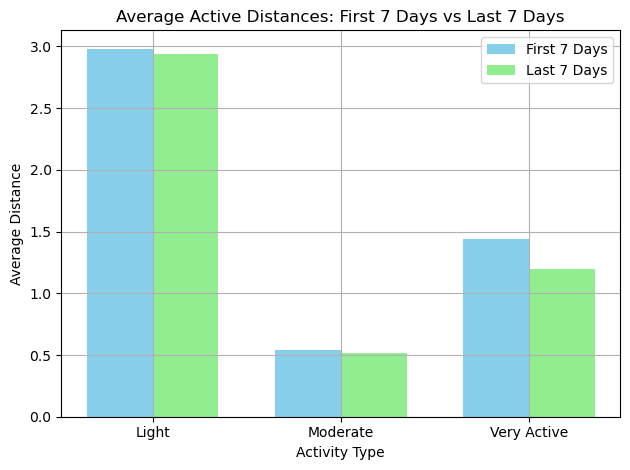

In [18]:
# Convert the date column to datetime format
cleaned_data['ActivityDate'] = pd.to_datetime(cleaned_data['ActivityDate'])

# Function to calculate the average distances for the first and last 7 days
def calculate_first_last_avg_distances(df):
    df = df.sort_values('ActivityDate')
    first_7_days = df.head(7)
    last_7_days = df.tail(7)
    return pd.Series({
        'First7_LightActiveDistance': first_7_days['LightActiveDistance'].mean(),
        'First7_ModerateActiveDistance': first_7_days['ModeratelyActiveDistance'].mean(),
        'First7_VeryActiveDistance': first_7_days['VeryActiveDistance'].mean(),
        'Last7_LightActiveDistance': last_7_days['LightActiveDistance'].mean(),
        'Last7_ModerateActiveDistance': last_7_days['ModeratelyActiveDistance'].mean(),
        'Last7_VeryActiveDistance': last_7_days['VeryActiveDistance'].mean()
    })

# Calculate the average distances for the first and last 7 days for each user
user_avg_distances = cleaned_data.groupby('Id').apply(calculate_first_last_avg_distances)

# Perform paired t-tests
t_test_results = {}
for activity in ['LightActiveDistance', 'ModerateActiveDistance', 'VeryActiveDistance']:
    t_stat, p_val = stats.ttest_rel(user_avg_distances[f'First7_{activity}'], user_avg_distances[f'Last7_{activity}'])
    t_test_results[activity] = (t_stat, p_val)

# Print t-test results
for activity, (t_stat, p_val) in t_test_results.items():
    print(f"T-test for {activity}: t-statistic = {t_stat}, p-value = {p_val}")

# Visualize the average distances for the first and last 7 days
average_distances = user_avg_distances.mean()

plt.figure(figsize=(12, 6))
x = np.arange(3)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [average_distances[f'First7_{activity}'] for activity in ['LightActiveDistance', 'ModerateActiveDistance', 'VeryActiveDistance']],
                width, label='First 7 Days', color='skyblue')
rects2 = ax.bar(x + width/2, [average_distances[f'Last7_{activity}'] for activity in ['LightActiveDistance', 'ModerateActiveDistance', 'VeryActiveDistance']],
                width, label='Last 7 Days', color='lightgreen')

ax.set_xlabel('Activity Type')
ax.set_ylabel('Average Distance')
ax.set_title('Average Active Distances: First 7 Days vs Last 7 Days')
ax.set_xticks(x)
ax.set_xticklabels(['Light', 'Moderate', 'Very Active'])
ax.legend()

fig.tight_layout()
plt.grid(True)

#plt.savefig('average_active_distances_hypo_test.png')

plt.show()

# Interpretation
T-Test Results:

P-values for all activity types are greater than 0.05: This indicates that there is no statistically significant difference between the first 7 days and the last 7 days for light active distance, moderate active distance, and very active distance.
T-statistics are relatively low: This further supports the conclusion that there are no significant differences in the average active distances over time.
Visualization:

Light Active Distance:
The average light active distance slightly decreased from the first 7 days (approx. 2.8) to the last 7 days (approx. 2.7). However, the decrease is very small.
Moderate Active Distance:
The average moderate active distance remained nearly the same from the first 7 days to the last 7 days (approx. 0.5).
Very Active Distance:
The average very active distance slightly increased from the first 7 days (approx. 1.2) to the last 7 days (approx. 1.5). This increase, while noticeable in the bar plot, is not statistically significant according to the t-test results.
Conclusion
Based on the t-test results and the visualization:

No Significant Increase or Decrease:

There is no statistically significant increase or decrease in the average active distances (light, moderate, very active) from the first 7 days to the last 7 days of the dataset.
Consistency in Activity Levels:

The average distances for light and moderate activities remained relatively consistent over time, suggesting that users maintained their activity levels throughout the survey duration.
Slight Increase in Very Active Distance:

Although there was a slight increase in the average very active distance, this change was not statistically significant. This suggests that while some users might have increased their very active minutes, the overall trend did not show a significant improvement. Possibly with a larger time frame some significant differences and changes can be observed.